In [1]:
# ---- Notebook setup (works in Jupyter & CLI) ----
from __future__ import annotations
import os, sys, json, time
from dataclasses import dataclass, asdict
from pathlib import Path
from typing import Tuple, Dict, List

%load_ext autoreload
%autoreload 2

# Keep OpenMP overlap tame
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
os.environ["OMP_NUM_THREADS"] = "1"

# Point to your repo root
REPO_ROOT = Path("/home/sionchun0331/projects/trading").resolve()
assert REPO_ROOT.exists(), REPO_ROOT
sys.path.insert(0, str(REPO_ROOT))
%cd {REPO_ROOT}

# Try both package and repo-relative imports
try:
    from trading.strategy.transformer_simple.dataset import EurusdTickDataset
    from trading.strategy.transformer_simple.model import TinyTransformer
except ModuleNotFoundError:
    from strategy.transformer_simple.dataset import EurusdTickDataset
    from strategy.transformer_simple.model import TinyTransformer

import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split

# --------- Where to save (optional) ----------
SAVE_TO_FILES = True  # << turn ON if you also want disk artifacts
OUT_DIR = (REPO_ROOT / "models" / "transformer_simple").resolve()
OUT_DIR.mkdir(parents=True, exist_ok=True)
METRICS_PATH = OUT_DIR / "eurusd_transformer_metrics.jsonl"
CONFIG_PATH  = OUT_DIR / "eurusd_transformer_config.json"
CKPT_PATH    = OUT_DIR / "eurusd_transformer.pt"
NORM_PATH    = OUT_DIR / "eurusd_transformer.norm.json"

print("Repo root:", REPO_ROOT)
print("Artifacts dir:", OUT_DIR)


/home/sionchun0331/projects/trading
Repo root: /home/sionchun0331/projects/trading
Artifacts dir: /home/sionchun0331/projects/trading/models/transformer_simple


In [2]:
@dataclass
class TrainConfig:
    symbol: str = "USDJPY"
    train_sd: str = "2025-06-01"
    train_ed: str = "2025-06-20"
    val_sd: str = "2025-06-21"
    val_ed: str = "2025-06-30"
    lookback: int = 120
    horizon: int = 20
    batch_size: int = 256
    epochs: int = 10
    val_frac: float = 0.10
    lr: float = 1e-3
    weight_decay: float = 1e-4
    seed: int = 42
    in_dim: int = 5
    num_classes: int = 3
    label_names: tuple[str, ...] = ("down", "flat", "up")

    def to_json(self) -> str:
        return json.dumps(asdict(self), indent=2)
        
# --- choose your training window/params here ---
cfg = TrainConfig(
    symbol="USDJPY",
    train_sd= "2025-06-01",
    train_ed= "2025-06-20",
    val_sd= "2025-06-21",
    val_ed= "2025-06-30",
    lookback=120,
    horizon=30,
    batch_size=256,
    epochs=30,
    val_frac=0.10,
    lr=1e-3,
    weight_decay=1e-4,
    seed=42,
    in_dim=5,
    num_classes=3,
    label_names=("down", "flat", "up"),
)

In [3]:
def save_config_once(cfg: TrainConfig):
    if SAVE_TO_FILES: # and not CONFIG_PATH.exists()
        CONFIG_PATH.write_text(cfg.to_json(), encoding="utf-8")

def log_metrics_row(metrics_buf: List[dict], epoch: int, train_loss: float, val_loss: float, val_acc: float):
    row = {
        "epoch": int(epoch),
        "train_loss": float(train_loss),
        "val_loss": float(val_loss),
        "val_acc": float(val_acc),
        "time": float(time.time()),
    }
    metrics_buf.append(row)
    if SAVE_TO_FILES:
        METRICS_PATH.parent.mkdir(parents=True, exist_ok=True)
        with METRICS_PATH.open("a", encoding="utf-8") as f:
            f.write(json.dumps({**row, "saved_path": str(CKPT_PATH) if CKPT_PATH.exists() else ""}) + "\n")


In [4]:
def make_dataset(cfg: TrainConfig) -> EurusdTickDataset:
    ds_train = EurusdTickDataset(
        symbol=cfg.symbol,
        start_iso=f"{cfg.train_sd}T00:00:00+00:00",
        end_iso=f"{cfg.train_ed}T23:59:59+00:00",
        lookback=cfg.lookback,
        horizon=cfg.horizon,
        classify=True,
    )
    ds_val = EurusdTickDataset(
        symbol=cfg.symbol,
        start_iso=f"{cfg.val_sd}T00:00:00+00:00",
        end_iso=f"{cfg.val_ed}T23:59:59+00:00",
        lookback=cfg.lookback,
        horizon=cfg.horizon,
        classify=True,
    )
    if len(ds_train) < 1000 or len(ds_val) < 1000:
        raise SystemExit(f"Not enough samples ({len(ds_train)} {len(ds_val)}). Extend date range.")
    return ds_train, ds_val

def make_loaders(ds_train: EurusdTickDataset, ds_val: EurusdTickDataset, cfg: TrainConfig) -> Tuple[DataLoader, DataLoader]:
    dl_train = DataLoader(ds_train, batch_size=cfg.batch_size, shuffle=True, drop_last=True)
    dl_val = DataLoader(ds_val, batch_size=cfg.batch_size, shuffle=False)
    return dl_train, dl_val

def build_model(cfg: TrainConfig, device: str) -> TinyTransformer:
    model = TinyTransformer(in_dim=cfg.in_dim, num_classes=cfg.num_classes)
    return model.to(device)

def _ensure_ce_labels(y: torch.Tensor) -> torch.Tensor:
    # shift {-1,0,1} -> {0,1,2} if needed
    if torch.min(y) < 0:
        y = y + 1
    return y

def train_epoch(model: torch.nn.Module, loader: DataLoader, opt: torch.optim.Optimizer, device: str) -> float:
    model.train()
    tot = 0.0
    for x, y in loader:
        x, y = x.to(device), _ensure_ce_labels(y.to(device))
        logits = model(x)
        loss = F.cross_entropy(logits, y)
        opt.zero_grad()
        loss.backward()
        opt.step()
        tot += float(loss.item()) * len(x)
    return tot / max(1, len(loader.dataset))

@torch.no_grad()
def eval_epoch(model: torch.nn.Module, loader: DataLoader, device: str) -> Tuple[float, float]:
    model.eval()
    tot, correct = 0.0, 0
    n = max(1, len(loader.dataset))
    for x, y in loader:
        x, y = x.to(device), _ensure_ce_labels(y.to(device))
        logits = model(x)
        loss = F.cross_entropy(logits, y)
        tot += float(loss.item()) * len(x)
        pred = logits.argmax(-1)
        correct += int((pred == y).sum().item())
    return tot / n, correct / n


In [5]:
ds_train, ds_val = make_dataset(cfg)
print(len(ds_train), len(ds_val))

dl_train, dl_val = make_loaders(ds_train, ds_val, cfg)
print(len(dl_train), len(dl_val))

Before Balancing: {0: 140154, 1: 1358649, 2: 141746}
After Balancing: {0: 140154, 1: 140154, 2: 140154}
Before Balancing: {0: 64807, 1: 574472, 2: 61667}
After Balancing: {0: 61667, 1: 61667, 2: 61667}
420462 185001
1642 723


In [ ]:
from IPython.display import display
import pandas as pd

def run_training(cfg: TrainConfig):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Running on:", "gpu" if device == "cuda" else device)

    save_config_once(cfg)
    
    model = build_model(cfg, device)
    opt = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)

    metrics_buf: List[dict] = []
    best = float("inf")
    for ep in range(1, cfg.epochs + 1):
        tr = train_epoch(model, dl_train, opt, device)
        va, acc = eval_epoch(model, dl_val, device)
        log_metrics_row(metrics_buf, ep, tr, va, acc)
        print(f"epoch {ep:02d} | train {tr:.4f} | val {va:.4f} | acc {acc:.3f}")

        if SAVE_TO_FILES and va < best:
            best = va
            CKPT_PATH.parent.mkdir(parents=True, exist_ok=True)
            torch.save({"state_dict": model.state_dict()}, CKPT_PATH)
            with open(NORM_PATH, "w", encoding="utf-8") as f:
                json.dump(getattr(ds_train, "norm", {}), f)
            print("saved:", CKPT_PATH)

    df = pd.DataFrame(metrics_buf)
    display(df)
    return {
        "cfg": cfg,
        "device": device,
        "ds_train": ds_train,
        "ds_val": ds_val,
        "dl_train": dl_train,
        "dl_val": dl_val,
        "model": model,
        "metrics": metrics_buf,
        "metrics_df": df,
    }

run_out = run_training(cfg)


Running on: gpu


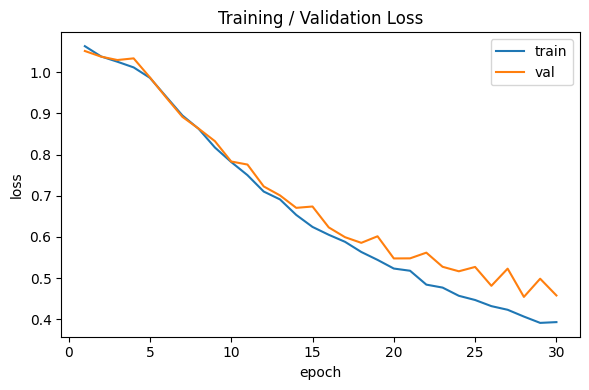

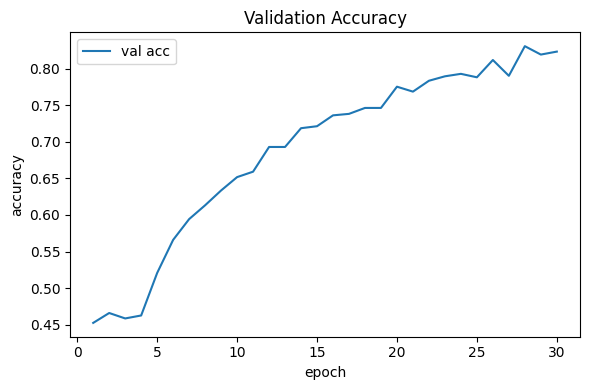

In [6]:
import matplotlib.pyplot as plt

m = run_out["metrics"]
if m:
    ep = [r["epoch"] for r in m]
    tr = [r["train_loss"] for r in m]
    va = [r["val_loss"] for r in m]
    acc = [r["val_acc"]  for r in m]

    # Loss
    plt.figure(figsize=(6,4))
    plt.plot(ep, tr, label="train")
    plt.plot(ep, va, label="val")
    plt.xlabel("epoch"); plt.ylabel("loss")
    plt.title("Training / Validation Loss"); plt.legend(); plt.tight_layout()
    plt.show()

    # Accuracy
    plt.figure(figsize=(6,4))
    plt.plot(ep, acc, label="val acc")
    plt.xlabel("epoch"); plt.ylabel("accuracy")
    plt.title("Validation Accuracy"); plt.legend(); plt.tight_layout()
    plt.show()


Before Balancing: {0: 5326, 1: 65191, 2: 4933}
After Balancing: {0: 4933, 1: 4933, 2: 4933}
Eval accuracy: 0.8951956213257652
Per-class precision: [0.90415273 0.87961727 0.89988515]
Per-class recall   : [0.93127914 0.80133793 0.9529698 ]
Per-class F1       : [0.91751548 0.83865493 0.92566703]


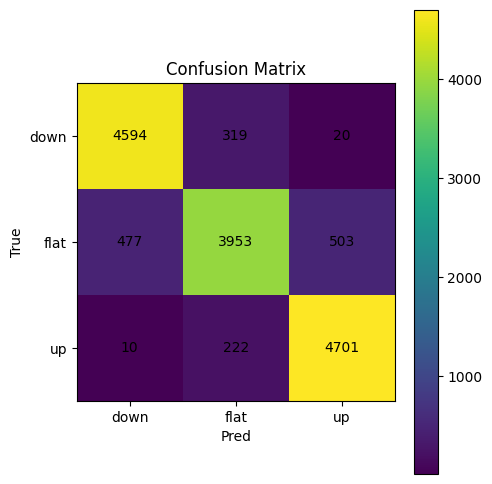

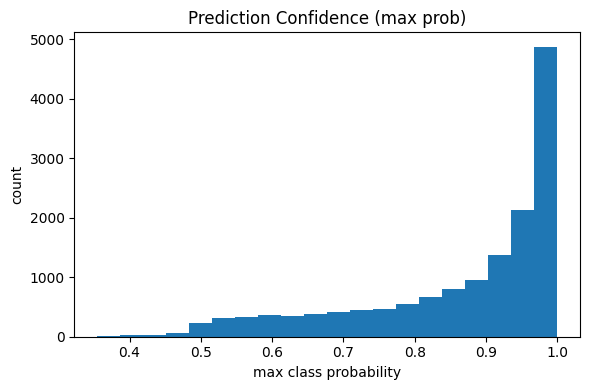

In [7]:
# --- evaluation config (can widen dates if you want) ---
@dataclass
class EvalConfig:
    symbol: str
    start_date: str
    end_date: str
    lookback: int
    horizon: int
    batch_size: int = 512
    label_names: Tuple[str, str, str] = ("down", "flat", "up")

def make_eval_dataset(cfg_eval: EvalConfig, norm_stats: dict | None) -> EurusdTickDataset:
    return EurusdTickDataset(
        symbol=cfg_eval.symbol,
        start_iso=f"{cfg_eval.start_date}T00:00:00+00:00",
        end_iso=f"{cfg_eval.end_date}T23:59:59+00:00",
        lookback=cfg_eval.lookback,
        horizon=cfg_eval.horizon,
        classify=True,
        stride=1,
        normalize=True,
        norm_stats=norm_stats,
    )

@torch.no_grad()
def eval_model(model: torch.nn.Module, dl: DataLoader, device: str) -> Dict[str, np.ndarray | float]:
    model.eval()
    ys, ps, pr = [], [], []
    for xb, yb in dl:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        probs = torch.softmax(logits, dim=-1)
        pred = probs.argmax(dim=-1)
        ys.append(yb.cpu().numpy())
        pr.append(pred.cpu().numpy())
        ps.append(probs.cpu().numpy())
    y_true = np.concatenate(ys) if ys else np.zeros((0,), dtype=np.int64)
    y_pred = np.concatenate(pr) if pr else np.zeros((0,), dtype=np.int64)
    probs  = np.concatenate(ps) if ps else np.zeros((0, run_out["cfg"].num_classes), dtype=np.float32)
    acc = float((y_true == y_pred).mean()) if len(y_true) else float("nan")
    return {"y_true": y_true, "y_pred": y_pred, "probs": probs, "accuracy": acc}

def confusion_matrix(y_true: np.ndarray, y_pred: np.ndarray, num_classes: int) -> np.ndarray:
    cm = np.zeros((num_classes, num_classes), dtype=int)
    for t, p in zip(y_true, y_pred):
        if 0 <= t < num_classes and 0 <= p < num_classes:
            cm[t, p] += 1
    return cm

def precision_recall_f1(cm: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    tp = np.diag(cm).astype(float)
    pred_pos = cm.sum(axis=0).astype(float)
    true_pos = cm.sum(axis=1).astype(float)
    with np.errstate(divide="ignore", invalid="ignore"):
        prec = np.where(pred_pos > 0, tp / pred_pos, 0.0)
        rec  = np.where(true_pos > 0, tp / true_pos, 0.0)
        f1   = np.where((prec + rec) > 0, 2*prec*rec / (prec + rec), 0.0)
    return prec, rec, f1

# pick eval range (here: same as training)
cfg_eval = EvalConfig(
    symbol=run_out["cfg"].symbol,
    start_date=run_out["cfg"].start_date,
    end_date=run_out["cfg"].end_date,
    lookback=run_out["cfg"].lookback,
    horizon=run_out["cfg"].horizon,
    label_names=run_out["cfg"].label_names,
)

# If your dataset computed normalization stats, grab them; else identity stats
norm_stats = getattr(run_out["dataset"], "norm", None) or {"feat_mean":[0]*run_out["cfg"].in_dim, "feat_std":[1]*run_out["cfg"].in_dim}

ds_eval = make_eval_dataset(cfg_eval, norm_stats)
dl_eval = DataLoader(ds_eval, batch_size=cfg_eval.batch_size, shuffle=False)

eval_out = eval_model(run_out["model"], dl_eval, run_out["device"])
print("Eval accuracy:", eval_out["accuracy"])

cm = confusion_matrix(eval_out["y_true"], eval_out["y_pred"], run_out["cfg"].num_classes)
prec, rec, f1 = precision_recall_f1(cm)
print("Per-class precision:", prec)
print("Per-class recall   :", rec)
print("Per-class F1       :", f1)

# --- Plots ---
import matplotlib.pyplot as plt
labels = list(cfg_eval.label_names)

# Confusion matrix
plt.figure(figsize=(5,5))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix"); plt.colorbar()
tick = np.arange(len(labels))
plt.xticks(tick, labels); plt.yticks(tick, labels)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(int(cm[i, j])), ha="center", va="center")
plt.ylabel("True"); plt.xlabel("Pred"); plt.tight_layout(); plt.show()

# Probability histogram
probs = eval_out["probs"]
if probs.size:
    plt.figure(figsize=(6,4))
    plt.hist(probs.max(axis=1), bins=20)
    plt.xlabel("max class probability"); plt.ylabel("count")
    plt.title("Prediction Confidence (max prob)"); plt.tight_layout(); plt.show()


In [8]:
from IPython.display import Markdown, display
best = min(run_out["metrics"], key=lambda r: r["val_loss"]) if run_out["metrics"] else None

report = []
report.append("# EURUSD Transformer — Training Analysis\n")
report.append("## Config\n```json")
report.append(run_out["cfg"].to_json())
report.append("```")

if best:
    report.append("## Best Validation")
    report.append(f"- Epoch: **{best['epoch']}**")
    report.append(f"- Val Loss: **{best['val_loss']:.4f}**")
    report.append(f"- Val Acc: **{best.get('val_acc', float('nan')):.3f}**")

report.append("\n## Evaluation")
report.append(f"- Eval range: `{cfg_eval.start_date}` → `{cfg_eval.end_date}`")
report.append(f"- Samples: `{len(eval_out['y_true'])}`")
report.append(f"- Accuracy: **{eval_out['accuracy']:.3f}**")

# Per-class table
labels = list(cfg_eval.label_names)
report.append("\n### Per-class metrics")
report.append("| class | precision | recall | f1 |")
report.append("|---|---:|---:|---:|")
for i, name in enumerate(labels):
    report.append(f"| {name} | {prec[i]:.3f} | {rec[i]:.3f} | {f1[i]:.3f} |")

display(Markdown("\n".join(report)))


# EURUSD Transformer — Training Analysis

## Config
```json
{
  "symbol": "EUR",
  "start_date": "2025-08-29",
  "end_date": "2025-08-29",
  "lookback": 120,
  "horizon": 30,
  "batch_size": 256,
  "epochs": 30,
  "val_frac": 0.1,
  "lr": 0.001,
  "weight_decay": 0.0001,
  "seed": 42,
  "in_dim": 5,
  "num_classes": 3,
  "label_names": [
    "down",
    "flat",
    "up"
  ]
}
```
## Best Validation
- Epoch: **28**
- Val Loss: **0.4542**
- Val Acc: **0.831**

## Evaluation
- Eval range: `2025-08-29` → `2025-08-29`
- Samples: `14799`
- Accuracy: **0.895**

### Per-class metrics
| class | precision | recall | f1 |
|---|---:|---:|---:|
| down | 0.904 | 0.931 | 0.918 |
| flat | 0.880 | 0.801 | 0.839 |
| up | 0.900 | 0.953 | 0.926 |